In [61]:
import psycopg2

# Database connection parameters: root_user
conn_string = "host='140.112.12.188' user='postgres' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)
print("Connection established")

# Create a cursor object
cursor = conn.cursor()
# Create Index on id_number
# try:
#     cursor.execute("CREATE INDEX index_id_number ON Patient (id_number);")
#     conn.commit()
# except psycopg2.Error as e:
#     print(f"Error : {e}")
#     conn.rollback()
# Define the SQL for creating the function with logging
create_function_sql = """
CREATE FUNCTION site_policy(row_site int8, curr_user text)
RETURNS bool
AS $$
BEGIN
    RETURN (
        (SELECT Site_ID
        FROM Doctor WHERE UserName = curr_user) 
        = row_site
        );

END;
$$
LANGUAGE plpgsql;
"""
# Define the SQL for enabling row-level security and creating the policy
enable_rls_sql = """
ALTER TABLE patient
ENABLE ROW LEVEL SECURITY;

CREATE POLICY doctor_read
ON Patient
USING (site_policy(Site_ID, current_user));
"""

# Execute the SQL commands
try:
    # Drop policy if it exists
    cursor.execute("DROP POLICY IF EXISTS doctor_read ON Patient;")
    cursor.execute("DROP FUNCTION IF EXISTS site_policy(int8, text);")
    # Create the function
    cursor.execute(create_function_sql)
    print("Function created successfully")
    # Enable row-level security and create the policy
    cursor.execute(enable_rls_sql)
    conn.commit()
    print("Row-level security enabled and policy created successfully")
    """
    cursor.execute("SELECT relrowsecurity, relforcerowsecurity FROM pg_catalog.pg_class WHERE relname = 'patient';")
    print(cursor.fetchall())
    cursor.execute("SELECT * FROM pg_policies WHERE policyname = 'doctor_read' AND tablename = 'patient';")
    print(cursor.fetchall())
    
    # Set application user ID using custom configuration        
    cursor.execute("SELECT set_config('app.current_user_id', '5', false);")
    
    # Execute the select query
    cursor.execute("SELECT * FROM patient WHERE ID_Number = '9666427225';")
    results = cursor.fetchall()
    print("Query executed successfully, results:")
    print(results)
    """
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")


# Close the cursor and connection
cursor.close()
conn.close()

Connection established
Function created successfully
Row-level security enabled and policy created successfully


In [99]:
# Unauthorized
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE SELECT * FROM Patient WHERE ID_number='3769016772';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=34) (actual time=0.042..0.043 rows=0 loops=1)',)
("  Index Cond: ((id_number)::text = '3769016772'::text)",)
('  Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.444 ms',)
('Execution Time: 0.696 ms',)


In [102]:
# Nonexist
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN SELECT * FROM Patient WHERE ID_number='12345678';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=34)',)
("  Index Cond: ((id_number)::text = '12345678'::text)",)
('  Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)


In [68]:
import time
# Doctor with site_ID 0
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)
#print("Connection established")

# Create a cursor object
cursor = conn.cursor()
Authorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[(9, 'John Doe', '3463370605', 35, 0)]


In [69]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)

36602.83


In [70]:
# Another user with no permission
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Unauthorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
    end_time = time.perf_counter_ns()
    Unauthorized.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [71]:
avg_Unauthorized = sum(Unauthorized)/len(Unauthorized)
print(avg_Unauthorized)

23896.439999999995


In [72]:
# Another user with no permission and ID isn't in dataset
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)
#print("Connection established")

# Create a cursor object
cursor = conn.cursor()
Non_Existent = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_number='37690167';")
    end_time = time.perf_counter_ns()
    Non_Existent.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [73]:
avg_Nonexist = sum(Non_Existent)/len(Non_Existent)
print(avg_Nonexist)

9108.844999999998


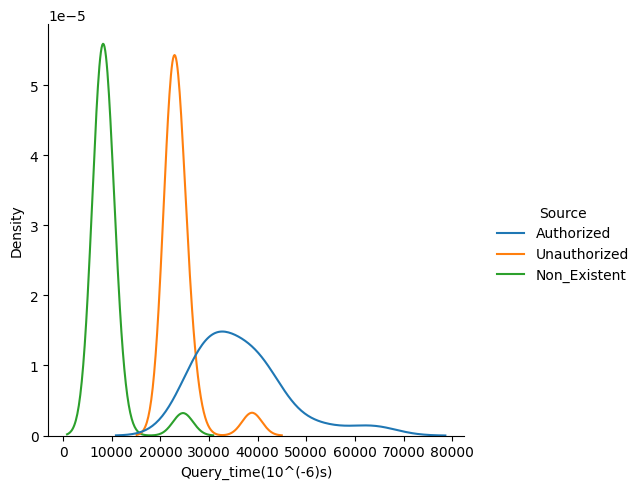

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#print(len(Unauthorized))
Authorized_arr = np.array(Authorized)
Authorized_df = pd.DataFrame(Authorized_arr, columns=['Query_time(10^(-6)s)'])
Unauthorized_arr = np.array(Unauthorized)
Unauthorized_df = pd.DataFrame(Unauthorized_arr, columns=['Query_time(10^(-6)s)'])
Non_Existent_arr = np.array(Non_Existent)
Non_Existent_df = pd.DataFrame(Non_Existent_arr, columns=['Query_time(10^(-6)s)'])

Authorized_df['Source'] = 'Authorized'
Unauthorized_df['Source'] = 'Unauthorized'
Non_Existent_df['Source'] = 'Non_Existent'

combined_df = pd.concat([Authorized_df, Unauthorized_df, Non_Existent_df], ignore_index=True)

sns.displot(data=combined_df, x='Query_time(10^(-6)s)', hue='Source', kind='kde')
plt.show()

In [59]:
# Update
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.00..278072.00 rows=0 width=0) (actual time=86.404..86.404 rows=0 loops=1)',)
('  ->  Seq Scan on patient  (cost=0.00..278072.00 rows=1 width=124) (actual time=63.482..63.545 rows=1 loops=1)',)
("        Filter: (((id_number)::text = '3463370605'::text) AND site_policy((site_id)::bigint, (CURRENT_USER)::text))",)
('        Rows Removed by Filter: 999999',)
('Planning Time: 0.419 ms',)
('JIT:',)
('  Functions: 5',)
('  Options: Inlining false, Optimization false, Expressions true, Deforming true',)
('  Timing: Generation 0.190 ms, Inlining 0.000 ms, Optimization 0.140 ms, Emission 2.478 ms, Total 2.807 ms',)
('Execution Time: 96.840 ms',)


In [58]:
# Update
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.00..278072.00 rows=0 width=0) (actual time=58.322..58.322 rows=0 loops=1)',)
('  ->  Seq Scan on patient  (cost=0.00..278072.00 rows=1 width=124) (actual time=58.321..58.321 rows=0 loops=1)',)
("        Filter: (((id_number)::text = '3463370605'::text) AND site_policy((site_id)::bigint, (CURRENT_USER)::text))",)
('        Rows Removed by Filter: 1000000',)
('Planning Time: 0.176 ms',)
('JIT:',)
('  Functions: 4',)
('  Options: Inlining false, Optimization false, Expressions true, Deforming true',)
('  Timing: Generation 0.135 ms, Inlining 0.000 ms, Optimization 0.099 ms, Emission 1.864 ms, Total 2.099 ms',)
('Execution Time: 67.163 ms',)


In [60]:
# Update
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN (FORMAT JSON) UPDATE Patient SET name='Updated' WHERE ID_Number='12345';")
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.00..278072.00 rows=0 width=0) (actual time=63.282..63.282 rows=0 loops=1)',)
('  ->  Seq Scan on patient  (cost=0.00..278072.00 rows=1 width=124) (actual time=63.281..63.281 rows=0 loops=1)',)
("        Filter: (((id_number)::text = '3463370605'::text) AND site_policy((site_id)::bigint, (CURRENT_USER)::text))",)
('        Rows Removed by Filter: 1000000',)
('Planning Time: 0.068 ms',)
('JIT:',)
('  Functions: 4',)
('  Options: Inlining false, Optimization false, Expressions true, Deforming true',)
('  Timing: Generation 0.172 ms, Inlining 0.000 ms, Optimization 0.110 ms, Emission 2.101 ms, Total 2.383 ms',)
('Execution Time: 63.487 ms',)


In [76]:
# Uddate
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Authorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated'  WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
print(cursor.fetchall())
cursor.close()
conn.close()

[(9, 'Updated', '3463370605', 35, 0)]


In [77]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)

42550.30500000001


In [78]:
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Unauthorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated'  WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Unauthorized.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [79]:
avg_Unauthorized = sum(Unauthorized)/len(Unauthorized)
print(avg_Unauthorized)

23962.144999999997


In [80]:
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Non_Existent = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated' WHERE ID_Number='12345';")
    end_time = time.perf_counter_ns()
    Non_Existent.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='12345';")
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [81]:
avg_Nonexist = sum(Non_Existent)/len(Non_Existent)
print(avg_Nonexist)

11230.100000000002


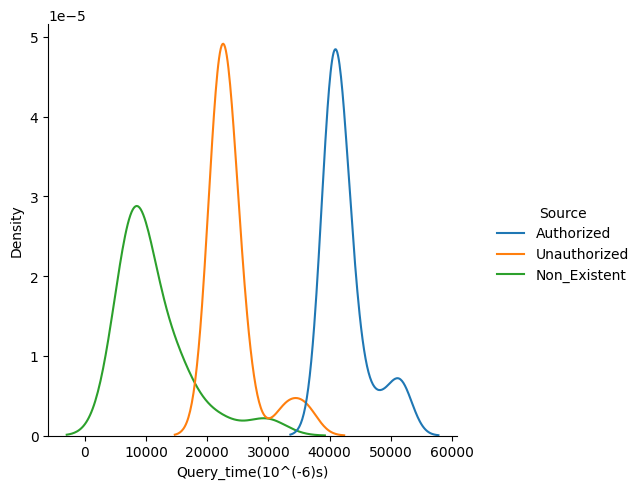

In [82]:
Authorized_arr = np.array(Authorized)
Authorized_df = pd.DataFrame(Authorized_arr, columns=['Query_time(10^(-6)s)'])
Unauthorized_arr = np.array(Unauthorized)
Unauthorized_df = pd.DataFrame(Unauthorized_arr, columns=['Query_time(10^(-6)s)'])
Non_Existent_arr = np.array(Non_Existent)
Non_Existent_df = pd.DataFrame(Non_Existent_arr, columns=['Query_time(10^(-6)s)'])

Authorized_df['Source'] = 'Authorized'
Unauthorized_df['Source'] = 'Unauthorized'
Non_Existent_df['Source'] = 'Non_Existent'

combined_df = pd.concat([Authorized_df, Unauthorized_df, Non_Existent_df], ignore_index=True)

sns.displot(data=combined_df, x='Query_time(10^(-6)s)', hue='Source', kind='kde')
plt.show()

In [97]:
# Insert (Debugging)
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
#print("Connection established")

cursor = conn.cursor()
Authorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("INSERT INTO Patient VALUES ('1000002', 'Insert_test', '123456789', '20', '0');")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='123456789';")
print(cursor.fetchall())
cursor.close()
conn.close()

UniqueViolation: duplicate key value violates unique constraint "patient_pkey"


In [ ]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)